In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

import gensim.downloader as api
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA

In [2]:
# notebook hparams
corpus_path = r"..\barrons_333_corpus.txt"
W2V_SIZE = 100    # Word vector dimensionality
W2V_WINDOW = 30   # Context window size
W2V_MIN_COUNT = 1    # Minimum word count
W2V_EPOCHS = 50    # w2v model training iters

np.set_printoptions(suppress=True)

In [3]:
# extracting gensim pretrained model & corpora info
def get_gensim_pretrained_info(entity, desc_len=None):
    """
    :param entity: either 'corpora' or 'models'
    :param desc_len: description length of each entity, entire description is printed if this is None
    :return: None
    """
    info = api.info()
    for entity_name, entity_data in sorted(info[entity].items()):
        print(f"{entity_name:<40} {entity_data.get('num_records', -1)} records: "
              f"{entity_data['description'][:desc_len] + '...'}")

In [4]:
# tokenize a corpus using nltk
def nltk_corpus_tokenizer(corpus):
    # tokenize sentences in corpus
    wpt = nltk.WordPunctTokenizer()
    tokenized_corpus = wpt.tokenize(corpus)
    return tokenized_corpus

In [5]:
# train a w2v model on a given corpus
def train_w2v_model(corpus, size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, iter=W2V_EPOCHS, workers=4):
    logging.info(f'word2vec model training started with params {size, window, min_count, iter, workers}')
    w2v_model = word2vec.Word2Vec(corpus,
                                  size=size,
                                  window=window,
                                  min_count=min_count,
                                  iter=iter,
                                  workers=workers)
    logging.info(f'word2vec model training completed..')
    return w2v_model

## extracting w2v feature vectors

In [6]:
get_gensim_pretrained_info('models', desc_len=80)
# w2v_model = train_w2v_model(tokenized_corpus)

__testing_word2vec-matrix-synopsis       -1 records: [THIS IS ONLY FOR TESTING] Word vecrors of the movie matrix....
conceptnet-numberbatch-17-06-300         1917247 records: ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known...
fasttext-wiki-news-subwords-300          999999 records: 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt...
glove-twitter-100                        1193514 records: Pre-trained vectors based on  2B tweets, 27B tokens, 1.2M vocab, uncased (https:...
glove-twitter-200                        1193514 records: Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https:/...
glove-twitter-25                         1193514 records: Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https:/...
glove-twitter-50                         1193514 records: Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https:/...
glove-wiki-gigaword-100         

In [7]:
with open(corpus_path, 'r') as f:
    barrons_corpus = f.read()
    
tokenized_corpus = nltk_corpus_tokenizer(barrons_corpus)
print(f'length of raw corpus: {len(tokenized_corpus)}')

length of raw corpus: 334


In [8]:
def filter_corpus_vocab(w2v_model, tokenized_corpus):
    trained_words = list()
    untrained_words = list()
    model_vocab = w2v_model.vocab
    for _word in tokenized_corpus:
        if _word in model_vocab:
            trained_words.append(_word)
        else:
            untrained_words.append(_word)
    
    print(f"w2v model doesn't have {len(untrained_words)} words: {untrained_words}")
    return trained_words

In [9]:
# load pre trained model
w2v_model = api.load("glove-wiki-gigaword-50")
tokenized_corpus = filter_corpus_vocab(w2v_model, tokenized_corpus)
print(f'length of filtered corpus: {len(tokenized_corpus)}')

w2v model doesn't have 3 words: ['desiccate', 'enervate', 'veracious']
length of filtered corpus: 331


In [10]:
# sample test runs
for _word in ["stop", "woman", "man", "abate", "india"]:
    neighbors = w2v_model.most_similar(_word, topn=5)
    print(neighbors)

[('stopping', 0.8896316885948181), ('stopped', 0.8306300640106201), ('trying', 0.8275439739227295), ('tried', 0.8172997832298279), ('stops', 0.8129743933677673)]
[('girl', 0.9065280556678772), ('man', 0.8860336542129517), ('mother', 0.8763703107833862), ('her', 0.86131352186203), ('boy', 0.8596119284629822)]
[('woman', 0.8860337734222412), ('boy', 0.8564431071281433), ('another', 0.8452839851379395), ('old', 0.8372182846069336), ('one', 0.8276063203811646)]
[('caputo', 0.6675522923469543), ('washpost.com', 0.6115913391113281), ('levesque', 0.6013662815093994), ('subside', 0.5964425206184387), ('greef', 0.5947305560112)]
[('indian', 0.8648794889450073), ('pakistan', 0.8529723286628723), ('malaysia', 0.816650927066803), ('bangladesh', 0.8154239058494568), ('delhi', 0.8142766952514648)]


In [11]:
# get word vectors for all corpus words
wvs = w2v_model.wv[tokenized_corpus]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


## TSNE visualization

In [12]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
T = tsne.fit_transform(wvs)

In [ ]:
labels = tokenized_corpus
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='green', edgecolors='b')

for _label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(_label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    
# texts = [plt.text(x+1, y+1, _label, ha='center', va='center') for _label, x, y in zip(labels, T[:, 0], T[:, 1])]
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

In [14]:
# build feature array for all tokens in corpus to cluster
w2v_feature_array = wvs.copy()  # if using barrons word meanings, average feature vectors

## AP clustering

In [15]:
# build ap clustering model
ap = AffinityPropagation()
ap.fit(w2v_feature_array)
corpus_clusters_df = pd.DataFrame({'words': tokenized_corpus, 'cluter_labels': ap.labels_})
print(f"the corpus is divided into {max(ap.labels_)+1} clusters")

the corpus is divided into 34 clusters


C:\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


In [16]:
corpus_clusters_df

,words,cluter_labels
0,abate,2
1,aberrant,4
2,abeyance,30
3,abscond,10
4,abstemious,18
...,...,...
326,volatile,27
327,wary,26
328,welter,13
329,whimsical,6


## PCA cluster visualization

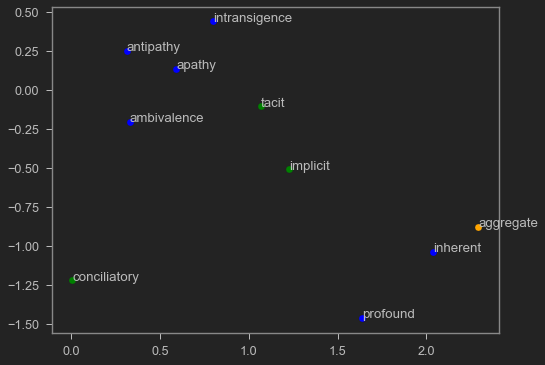

In [17]:
pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)

categories = tokenized_corpus
labels = ap.labels_
plt.figure(figsize=(8, 6))

disp_labels = [0, 1, 33]  # min thre clusters
for i in range(len(labels)):
    label = labels[i]
    if label in disp_labels:
        color = 'orange' if label == disp_labels[0] else 'blue' if label == disp_labels[1] else 'green'
        annotation_label = categories[i]
        x, y = pcs[i]
        plt.scatter(x, y, c=color, edgecolors='k')
        plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')
